## Fine-tuning BERT, RoBERTa, and DistilBERT on Amazon Sample Sentiment Dataset

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import TFAutoModel, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Create metrics folder if not exists
os.makedirs("metrics", exist_ok=True)

In [3]:
# Load dataset
df = pd.read_csv("cleaned_amazon.csv")
df = df.dropna()


In [4]:
# Convert to strings
df['clean_text'] = df['clean_text'].astype(str)
df['label'] = df['label'].astype(int)


In [5]:
# Split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=test_size, stratify=df['label'], random_state=42)

In [8]:
# Parameters
max_len = 128
batch_size = 16
epochs = 3
results=[]

# BERT

The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'tf_bert_model_1/bert/embeddings/word_embeddings/weight:0' shape=(30522, 768) dtype=float32>
  <tf.Variable 'tf_bert_model_1/bert/embeddings/token_type_embeddings/embeddings:0' shape=(2, 768) dtype=float32>
  <tf.Variable 'tf_bert_model_1/bert/embeddings/position_embeddings/embeddings:0' shape=(512, 768) dtype=float32>
  <tf.Variable 'tf_bert_model_1/bert/embeddings/LayerNorm/gamma:0' shape=(768,) dtype=float32>
  <tf.Variable 'tf_bert_model_1/bert/embeddings/LayerNorm/beta:0' shape=(768,) dtype=float32>
  <tf.Variable 'tf_bert_model_1/bert/encoder/layer_._0/attention/self/query/kernel:0' shape=(768, 768) dtype=float32>
  <tf.Variable 'tf_bert_model_1/bert/encoder/layer_._0/attention/self/query/bias:0' shape=(768,) dtype=float32>
  <tf.Variable 'tf_bert_model_1/bert/encoder/layer_._0/attention/self/key/kernel:0' shape=(768, 768) dtype=float32>
  <tf.Variable 't

C:\Users\ATHAK\AppData\Roaming\Python\Python312\site-packages\tf_keras\src\engine\functional.py:641: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


50/50 [==============================] - 317s 6s/step - loss: 0.7379 - accuracy: 0.5088 - val_loss: 0.6969 - val_accuracy: 0.5150
Epoch 2/3
50/50 [==============================] - 283s 6s/step - loss: 0.7226 - accuracy: 0.5175 - val_loss: 0.6913 - val_accuracy: 0.5350
Epoch 3/3
13/13 [==============================] - 60s 4s/step


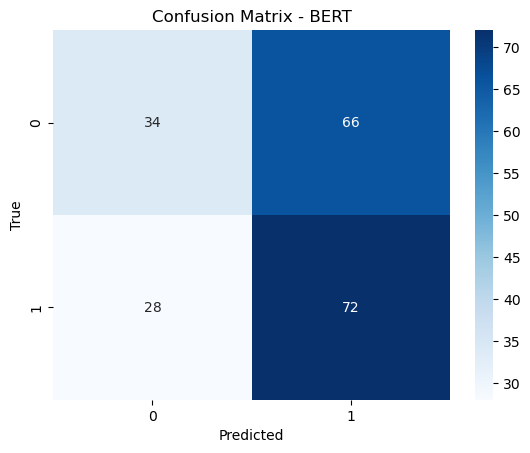

In [9]:
from transformers import AutoTokenizer, TFAutoModel
from transformers.utils import logging
import os

# Suppress display widget and tqdm issues
os.environ["TRANSFORMERS_NO_TQDM"] = "1"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"
logging.set_verbosity_error()

# Tokenizer and model
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased")
base_bert = TFAutoModel.from_pretrained("bert-base-uncased")

# Encode data
train_enc_bert = tokenizer_bert(
    list(X_train),
    truncation=True,
    padding='max_length', 
    max_length=max_len,
    return_tensors="tf"
)

test_enc_bert = tokenizer_bert(
    list(X_test),
    truncation=True,
    padding='max_length',  
    max_length=max_len,
    return_tensors="tf"
)

train_data_bert = tf.data.Dataset.from_tensor_slices((dict(train_enc_bert), y_train)).batch(batch_size)
test_data_bert = tf.data.Dataset.from_tensor_slices((dict(test_enc_bert), y_test)).batch(batch_size)

# Functional model with Lambda fix
input_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

def transformer_encoder(inputs):
    return base_bert(inputs)[1]  # pooled output (CLS token)

bert_output = tf.keras.layers.Lambda(
    transformer_encoder,
    output_shape=(768,)  # BERT's CLS pooled output shape
)([input_ids, attention_mask])
x = tf.keras.layers.Dense(128, activation='relu')(bert_output)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_bert = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
model_bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                   loss='binary_crossentropy', metrics=['accuracy'])

model_bert.fit(train_data_bert, epochs=epochs, validation_data=test_data_bert, verbose=1)

# Predictions and confusion matrix
preds_bert = model_bert.predict(test_data_bert)
y_pred_bert = (preds_bert.flatten() > 0.5).astype(int)

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm_bert = confusion_matrix(y_test, y_pred_bert)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - BERT")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

results.append({
    "Model": "BERT",
    "Accuracy": np.mean(y_pred_bert == y_test),
    "F1-Score": classification_report(y_test, y_pred_bert, output_dict=True)['weighted avg']['f1-score'],
    "Parameters": model_bert.count_params()
})


=== RoBERTa Training ===


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:  43%|####3     | 377M/876M [00:00<?, ?B/s]

The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'tf_roberta_model/roberta/encoder/layer_._0/attention/self/query/kernel:0' shape=(768, 768) dtype=float32>
  <tf.Variable 'tf_roberta_model/roberta/encoder/layer_._0/attention/self/query/bias:0' shape=(768,) dtype=float32>
  <tf.Variable 'tf_roberta_model/roberta/encoder/layer_._0/attention/self/key/kernel:0' shape=(768, 768) dtype=float32>
  <tf.Variable 'tf_roberta_model/roberta/encoder/layer_._0/attention/self/key/bias:0' shape=(768,) dtype=float32>
  <tf.Variable 'tf_roberta_model/roberta/encoder/layer_._0/attention/self/value/kernel:0' shape=(768, 768) dtype=float32>
  <tf.Variable 'tf_roberta_model/roberta/encoder/layer_._0/attention/self/value/bias:0' shape=(768,) dtype=float32>
  <tf.Variable 'tf_roberta_model/roberta/encoder/layer_._0/attention/output/dense/kernel:0' shape=(768, 768) dtype=float32>
  <tf.Variable 'tf_roberta_model/roberta/encoder/layer

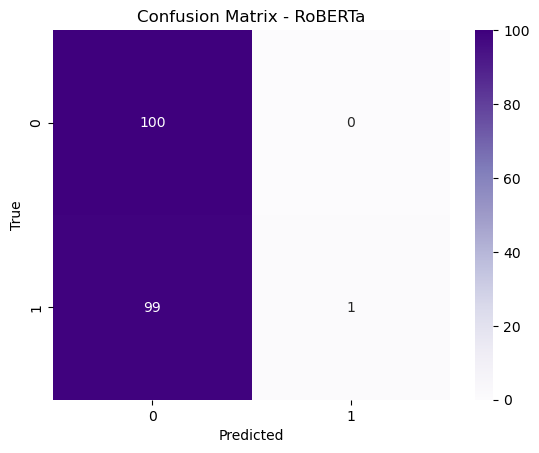

In [11]:
print("\n=== RoBERTa Training ===")
# Suppress display widget and tqdm issues
os.environ["TRANSFORMERS_NO_TQDM"] = "1"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"
logging.set_verbosity_error()


# Tokenizer & model
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
roberta_model = TFAutoModel.from_pretrained("roberta-base")

# Tokenize
train_enc_roberta = roberta_tokenizer(list(X_train), truncation=True, padding='max_length', max_length=max_len, return_tensors="tf")
test_enc_roberta = roberta_tokenizer(list(X_test), truncation=True, padding='max_length', max_length=max_len, return_tensors="tf")

train_data_roberta = tf.data.Dataset.from_tensor_slices((dict(train_enc_roberta), y_train)).batch(batch_size)
test_data_roberta = tf.data.Dataset.from_tensor_slices((dict(test_enc_roberta), y_test)).batch(batch_size)

# Inputs
input_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# Lambda wrapper
def roberta_encoder(inputs):
    return roberta_model(inputs)[1]  # CLS pooled output

roberta_output = tf.keras.layers.Lambda(roberta_encoder, output_shape=(768,))([input_ids, attention_mask])
x = tf.keras.layers.Dense(128, activation='relu')(roberta_output)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_roberta = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
model_roberta.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

model_roberta.fit(train_data_roberta, epochs=epochs, validation_data=test_data_roberta, verbose=1)

# Predict & Evaluate
preds_roberta = model_roberta.predict(test_data_roberta)
y_pred_roberta = (preds_roberta.flatten() > 0.5).astype(int)

cm_roberta = confusion_matrix(y_test, y_pred_roberta)
sns.heatmap(cm_roberta, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - RoBERTa")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

results.append({
    "Model": "RoBERTa",
    "Accuracy": np.mean(y_pred_roberta == y_test),
    "F1-Score": classification_report(y_test, y_pred_roberta, output_dict=True)['weighted avg']['f1-score'],
    "Parameters": model_roberta.count_params()
})


=== DistilBERT Training ===


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\ATHAK\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ATHAK\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

The following Variables were used a Lambda layer's call (lambda_3), but
are not present in its tracked objects:
  <tf.Variable 'tf_distil_bert_model/distilbert/embeddings/word_embeddings/weight:0' shape=(30522, 768) dtype=float32>
  <tf.Variable 'tf_distil_bert_model/distilbert/embeddings/position_embeddings/embeddings:0' shape=(512, 768) dtype=float32>
  <tf.Variable 'tf_distil_bert_model/distilbert/embeddings/LayerNorm/gamma:0' shape=(768,) dtype=float32>
  <tf.Variable 'tf_distil_bert_model/distilbert/embeddings/LayerNorm/beta:0' shape=(768,) dtype=float32>
  <tf.Variable 'tf_distil_bert_model/distilbert/transformer/layer_._0/attention/q_lin/kernel:0' shape=(768, 768) dtype=float32>
  <tf.Variable 'tf_distil_bert_model/distilbert/transformer/layer_._0/attention/q_lin/bias:0' shape=(768,) dtype=float32>
  <tf.Variable 'tf_distil_bert_model/distilbert/transformer/layer_._0/attention/k_lin/kernel:0' shape=(768, 768) dtype=float32>
  <tf.Variable 'tf_distil_bert_model/distilbert/transfo

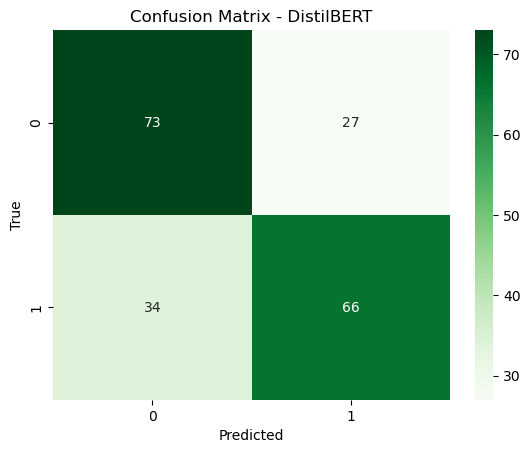

In [12]:
print("\n=== DistilBERT Training ===")
os.environ["TRANSFORMERS_NO_TQDM"] = "1"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"
logging.set_verbosity_error()

distil_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
distil_model = TFAutoModel.from_pretrained("distilbert-base-uncased")

train_enc_distil = distil_tokenizer(list(X_train), truncation=True, padding='max_length', max_length=max_len, return_tensors="tf")
test_enc_distil = distil_tokenizer(list(X_test), truncation=True, padding='max_length', max_length=max_len, return_tensors="tf")

train_data_distil = tf.data.Dataset.from_tensor_slices((dict(train_enc_distil), y_train)).batch(batch_size)
test_data_distil = tf.data.Dataset.from_tensor_slices((dict(test_enc_distil), y_test)).batch(batch_size)

input_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

def distilbert_encoder(inputs):
    return distil_model(inputs)[0][:, 0, :]  # Use first token (CLS equivalent)

distil_output = tf.keras.layers.Lambda(distilbert_encoder, output_shape=(768,))([input_ids, attention_mask])
x = tf.keras.layers.Dense(128, activation='relu')(distil_output)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_distil = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
model_distil.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

model_distil.fit(train_data_distil, epochs=epochs, validation_data=test_data_distil, verbose=1)

preds_distil = model_distil.predict(test_data_distil)
y_pred_distil = (preds_distil.flatten() > 0.5).astype(int)

cm_distil = confusion_matrix(y_test, y_pred_distil)
sns.heatmap(cm_distil, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - DistilBERT")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

results.append({
    "Model": "DistilBERT",
    "Accuracy": np.mean(y_pred_distil == y_test),
    "F1-Score": classification_report(y_test, y_pred_distil, output_dict=True)['weighted avg']['f1-score'],
    "Parameters": model_distil.count_params()
})

In [14]:
from sklearn.metrics import classification_report

print("===== BERT Classification Report =====")
print(classification_report(y_test, y_pred_bert, target_names=["Negative", "Positive"]))

print("\n===== RoBERTa Classification Report =====")
print(classification_report(y_test, y_pred_roberta, target_names=["Negative", "Positive"]))

print("\n===== DistilBERT Classification Report =====")
print(classification_report(y_test, y_pred_distil, target_names=["Negative", "Positive"]))

===== BERT Classification Report =====
              precision    recall  f1-score   support

    Negative       0.55      0.34      0.42       100
    Positive       0.52      0.72      0.61       100

    accuracy                           0.53       200
   macro avg       0.54      0.53      0.51       200
weighted avg       0.54      0.53      0.51       200


===== RoBERTa Classification Report =====
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67       100
    Positive       1.00      0.01      0.02       100

    accuracy                           0.51       200
   macro avg       0.75      0.51      0.34       200
weighted avg       0.75      0.51      0.34       200


===== DistilBERT Classification Report =====
              precision    recall  f1-score   support

    Negative       0.68      0.73      0.71       100
    Positive       0.71      0.66      0.68       100

    accuracy                           0.69       200


In [19]:
from sklearn.metrics import classification_report, accuracy_score

# Get reports as dictionaries
report_bert = classification_report(y_test, y_pred_bert, output_dict=True, zero_division=0)
report_roberta = classification_report(y_test, y_pred_roberta, output_dict=True, zero_division=0)
report_distil = classification_report(y_test, y_pred_distil, output_dict=True, zero_division=0)

# Accuracy
acc_bert = accuracy_score(y_test, y_pred_bert)
acc_roberta = accuracy_score(y_test, y_pred_roberta)
acc_distil = accuracy_score(y_test, y_pred_distil)

# Collect into DataFrame
import pandas as pd

transformer_results = pd.DataFrame([
    {
        "Model": "BERT",
        "Accuracy": acc_bert,
        "F1-Score": report_bert["weighted avg"]["f1-score"],
        "Precision": report_bert["weighted avg"]["precision"],
        "Recall": report_bert["weighted avg"]["recall"],
    },
    {
        "Model": "RoBERTa",
        "Accuracy": acc_roberta,
        "F1-Score": report_roberta["weighted avg"]["f1-score"],
        "Precision": report_roberta["weighted avg"]["precision"],
        "Recall": report_roberta["weighted avg"]["recall"],
    },
    {
        "Model": "DistilBERT",
        "Accuracy": acc_distil,
        "F1-Score": report_distil["weighted avg"]["f1-score"],
        "Precision": report_distil["weighted avg"]["precision"],
        "Recall": report_distil["weighted avg"]["recall"],
    },
])

In [20]:
print(transformer_results.round(4))

        Model  Accuracy  F1-Score  Precision  Recall
0        BERT     0.530    0.5124     0.5351   0.530
1     RoBERTa     0.505    0.3443     0.7513   0.505
2  DistilBERT     0.695    0.6946     0.6960   0.695


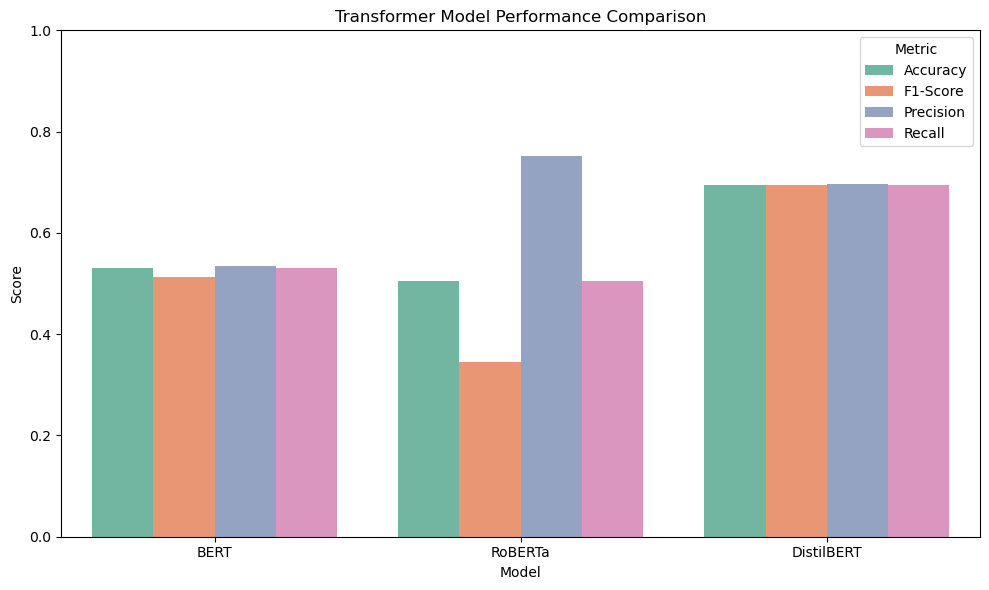

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=transformer_results.melt(id_vars="Model"), x="Model", y="value", hue="variable", palette="Set2")
plt.title("Transformer Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

In [23]:
# BERT
model_bert.save("best_model_bert.h5")

# RoBERTa
model_roberta.save("best_model_roberta.h5")

# DistilBERT
model_distil.save("best_model_distil.h5")

In [28]:
transformer_df = pd.DataFrame(transformer_results)
transformer_df.to_csv("metrics/transformer_model_comparison.csv", index=False)